In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uproot, wandb, os, logging, json, random
import awkward as ak
from copy import deepcopy
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import randint, uniform

# ML
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ML model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Tensorflow
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/jlai/.local/share/mamba/envs/tf-gpu"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# wandb
import wandb
from wandb.integration.keras import WandbMetricsLogger

# Config
from bdt_config import sample_dict, zbi, getVarDict
from bdt_config import Vars, Vars2, Vars3, Vars_drop, Vars_plot
from bdt_config import variables, ntuple_name, ntuple_name_BDT

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

# Check for gpu
# torch.cuda.is_available()

2025-08-21 04:31:47.195160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755750707.212318     894 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755750707.218532     894 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-21 04:31:47.236514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# path = '/data/projects/campfire-workshop/dark_photon/ML_input/BDT_input_basic.csv'
path = '/data/jlai/ntups/csv/jet_faking_BDT_input_basic2.csv'  
df = pd.read_csv(path)
df.describe()

,balance,BDTScore,dmet,dphi_jj,dphi_met_central_jet,dphi_met_phterm,dphi_met_ph,dphi_met_jetterm,dphi_phterm_jetterm,dphi_ph_centraljet1,...,metsig,metsigres,met,met_noJVT,metplusph,failJVT_jet_pt1,softerm,n_jet_central,weights,label
count,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,...,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06,3.299733e+06
mean,-1.745489e+02,1.251438e-01,-1.663472e+03,-4.654471e+02,-1.848742e+02,4.027364e-01,2.738863e+00,-1.317202e+02,-1.313245e+02,-1.842713e+02,...,1.190690e+01,2.709180e+04,1.947991e+05,1.931356e+05,8.173447e+05,8.082155e+03,9.400769e+03,1.752871e+00,6.037499e-01,1.390112e-03
std,3.835393e+02,1.348625e-01,1.103691e+04,4.990919e+02,3.894295e+02,6.314438e-01,6.313106e-01,3.400961e+02,3.402509e+02,3.897176e+02,...,1.038910e+01,2.307818e+04,1.623949e+05,1.632818e+05,8.139494e+05,1.485037e+04,5.880428e+03,1.232225e+00,7.646898e+00,3.725829e-02
min,-9.990000e+02,-3.265468e-01,-1.712589e+05,-9.990000e+02,-9.990000e+02,0.000000e+00,1.167295e-02,-9.990000e+02,-9.990000e+02,-9.990000e+02,...,2.269695e-01,8.526343e+03,1.000000e+05,2.001940e+03,1.500329e+05,-9.990000e+02,0.000000e+00,0.000000e+00,-9.143369e+01,0.000000e+00
25%,9.546858e-01,8.068899e-03,0.000000e+00,-9.990000e+02,4.369926e-02,5.094965e-02,2.728096e+00,2.204334e-01,5.477069e-01,3.878704e-01,...,3.802686e+00,1.057160e+04,1.177408e+05,1.162434e+05,2.738635e+05,-9.990000e+02,4.993511e+03,1.000000e+00,1.026595e-04,0.000000e+00
50%,1.283851e+00,1.647640e-01,0.000000e+00,1.517193e-01,4.694079e-01,1.503438e-01,2.991172e+00,1.017702e+00,2.089735e+00,2.023582e+00,...,1.024574e+01,1.767059e+04,1.480967e+05,1.473863e+05,4.551331e+05,-9.990000e+02,8.329055e+03,2.000000e+00,1.174600e-02,0.000000e+00
75%,2.922425e+00,2.371679e-01,0.000000e+00,1.378248e+00,2.476912e+00,4.133940e-01,3.090613e+00,2.863652e+00,3.105098e+00,3.039348e+00,...,1.590387e+01,3.643209e+04,2.160463e+05,2.158321e+05,1.013744e+06,2.159741e+04,1.265224e+04,3.000000e+00,5.386639e-02,0.000000e+00
max,2.663229e+02,4.375860e-01,1.246841e+05,3.141591e+00,3.141592e+00,3.141593e+00,3.141593e+00,3.141593e+00,3.141593e+00,3.141592e+00,...,2.823775e+02,6.173285e+06,1.470684e+08,1.470684e+08,1.490961e+08,5.999986e+04,1.022158e+05,4.000000e+00,1.221239e+04,1.000000e+00


In [3]:
# === Data Perparation ===
df_Vars2 = df[Vars2].copy()  # upright variables
df_Vars3 = df[Vars3].copy()  # inversed variables
df_Vars3.replace(-999, np.nan, inplace=True)
df_Vars3_inverted = 1 / df_Vars3.replace({0: np.nan})  # Avoid division by zero

df_ml_input = pd.concat([df_Vars2, df_Vars3_inverted], axis=1)
df_ml_input.replace(-999, np.nan, inplace=True)
print("Number of event with negative weights :", np.sum(df_ml_input.weights < 0))
df_ml_input["weights"] = df_ml_input["weights"].abs() # some of the weights are negative

# Renormalize weighting for signal and bkg
sum_weights_signal = sum(df_ml_input[df_ml_input.label == 1].weights)
sum_weights_bkg = sum(df_ml_input[df_ml_input.label == 0].weights)
df_ml_input2 = df_ml_input.copy()
mask_sig = df_ml_input2.label == 1
df_ml_input2.loc[mask_sig, 'weights'] = df_ml_input.loc[mask_sig, 'weights'] * (sum_weights_bkg / sum_weights_signal)
print('signal sum weight after:', sum(df_ml_input[df_ml_input.label == 1].weights), ' bkg sum weight: ', sum(df_ml_input[df_ml_input.label == 0].weights))
print('signal sum weight after:', sum(df_ml_input2[df_ml_input2.label == 1].weights), ' bkg sum weight: ', sum(df_ml_input2[df_ml_input2.label == 0].weights))

print("Number of nan in each variable: ")
print(df_ml_input.isna().sum())

X = df_ml_input.drop(Vars_drop, axis=1)
non_zero_nan = X.isna().sum()
non_zero_nan_loc = np.where(np.array(non_zero_nan) != 0)
non_zero_nan_keys = non_zero_nan.keys()[non_zero_nan_loc]
for key in non_zero_nan_keys:
    X[key+"_is_nan"] = X[key].isnull().astype(int)

y = df_ml_input['label']
weights = df_ml_input['weights']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # mean = 0, sigma = 1
X_scaled[np.isnan(X_scaled)] = 2.5  # setting the nan values to 2.5 sigma (still within the range)

feature_names = list(X.columns)

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_scaled, y, weights, test_size=0.3, stratify=y, random_state=42
)

Number of event with negative weights : 218306
signal sum weight after: 461.92219571760535  bkg sum weight:  2044177.3406631786
signal sum weight after: 2044177.3406631823  bkg sum weight:  2044177.3406631786
Number of nan in each variable: 
balance                  586964
BDTScore                      0
dmet                          1
dphi_jj                 1539870
dphi_met_central_jet     614421
dphi_met_phterm               0
dphi_phterm_jetterm      439783
ph_phi                        0
jet_central_eta          586964
jet_central_pt2         1539870
jetterm                       0
metsig                        0
metsigres                     0
met_noJVT                     0
softerm                       0
n_jet_central                 0
weights                       0
label                         0
process                       0
ph_eta                        0
ph_pt                         0
dtype: int64


In [4]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'final_val_roc_auc',
        'goal': 'maximize'
    },
    'parameters': {
        'lr': {
            'distribution': 'log_uniform_values',
            'min': 1e-5,
            'max': 1e-2
        },
        'batch_size': {
            'values': [128, 256, 512, 768, 1024]
        },
        'dropout': {
            'distribution': 'uniform',
            'min': 0.1,
            'max': 0.5
        },
        'layer_1': {
            'values': [64, 128, 192, 256]
        },
        'layer_2': {
            'values': [128, 192, 256, 384, 512]
        },
        'layer_3': {
            'values': [512, 768, 1024, 1536, 2048]
        },
        'layer_4': {
            'values': [128, 256, 384, 512]
        },
        'layer_5': {
            'values': [32, 64, 96, 128]
        },
        'epochs': {
            'value': 50
        }
    }
}

def compute_significance(df, score_column="bdtscore", cut=0.01):
    sig = df[(df["label"] == 1) & (df[score_column] >= cut)]["weights"].sum()
    bkg = df[(df["label"] == 0) & (df[score_column] >= cut)]["weights"].sum()
    return sig / np.sqrt(bkg) if bkg > 0 else 0, sig/df[(df["label"] == 1)]["weights"].sum()

def train():
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    wandb.init(project="tf-dnn-weighted-classifier")
    config = wandb.config

    model = Sequential()
    model.add(Dense(config.layer_1, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(config.dropout))
    model.add(Dense(config.layer_2, activation='relu'))
    model.add(Dropout(config.dropout))
    model.add(Dense(config.layer_3, activation='relu'))
    model.add(Dropout(config.dropout))
    model.add(Dense(config.layer_4, activation='relu'))
    model.add(Dropout(config.dropout))
    model.add(Dense(config.layer_5, activation='relu'))
    model.add(Dropout(config.dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config.lr),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(name="auc"),
        ],
        weighted_metrics=[
            tf.keras.metrics.AUC(name="weighted_auc")
        ]
    )

    early_stop = EarlyStopping(
        monitor="val_weighted_auc",
        patience=5,
        mode="max",
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test, w_test),
        sample_weight=w_train,
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=[early_stop, WandbMetricsLogger()],
        verbose=1
    )

    probs = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, probs, sample_weight=w_test)
    fpr, tpr, _ = roc_curve(y_test, probs, sample_weight=w_test)

    wandb.log({"final_val_roc_auc": auc})
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    wandb.log({"ROC Curve": wandb.Image(plt)})
    plt.close()

    X_scaled_array = np.asarray(X_scaled)
    nn_scores = model.predict(X_scaled_array, batch_size=config.batch_size).flatten()  # shape: (n_samples,)
    
    df_tmp = df_ml_input.copy()
    df_ml_input['nn_scores'] = nn_scores

    best_significance, best_acceptance, best_cut = 0, 0, 0
    for cut in np.arange(0, 0.15, 0.01):
        sig, acc = compute_significance(df_tmp, score_column="nn_scores", cut=cut)
        if sig > best_significance:
            best_significance = sig
            best_acceptance = acc
            best_cut = cut

    wandb.log({
        "Max S/sqrt(B)": best_significance,
        "Acceptance": best_acceptance,
        "nnScore cut": best_cut
    })
    
    wandb.finish()

sweep_id = wandb.sweep(sweep_config, project="tf-dnn-weighted-classifier")
wandb.agent(sweep_id, function=train, count=50) 

Create sweep with ID: rg1dnn5u
Sweep URL: https://wandb.ai/dlai211/tf-dnn-weighted-classifier/sweeps/rg1dnn5u


wandb: Agent Starting Run: siefxoek with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.4566775965699654
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 384
wandb: 	layer_3: 768
wandb: 	layer_4: 512
wandb: 	layer_5: 64
wandb: 	lr: 0.0035245432915081637
wandb: Currently logged in as: dlai211 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755750737.846000     961 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9615 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:89:00.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1755750740.583615    1100 service.cc:148] XLA service 0x7fb7e4002360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755750740.583652    1100 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-08-21 04:32:20.627376: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755750740.832789    1100 cuda_dnn.cc:529] Loaded cuDNN version 91001


  62/2256 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.5131 - loss: 0.0431 - weighted_auc: 0.5102

I0000 00:00:1755750743.584845    1100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2256/2256 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - auc: 0.6854 - loss: 0.0035 - weighted_auc: 0.6942 - val_auc: 0.7760 - val_loss: 9.3207e-04 - val_weighted_auc: 0.7903
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.7356 - loss: 0.0012 - weighted_auc: 0.7456 - val_auc: 0.5820 - val_loss: 0.0015 - val_weighted_auc: 0.5828
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.7574 - loss: 0.0012 - weighted_auc: 0.7662 - val_auc: 0.7646 - val_loss: 0.0010 - val_weighted_auc: 0.7733
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7917 - loss: 0.0011 - weighted_auc: 0.8017 - val_auc: 0.8026 - val_loss: 9.8101e-04 - val_weighted_auc: 0.8097
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8152 - loss: 0.0010 - weighted_auc: 0.8249 - val_auc: 0.8083 - val_loss: 8.7928e-04 - val_weighted_auc: 0.8165
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8252 - loss: 0.0010 - weighted_auc: 0.8324 - val_auc: 0.7242 - val_loss: 9.6301e-04 -

epoch/auc,▆▆▇▇████▅▁▃▅▇█
epoch/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▁▁▁▃▂▃▂▂▂▂
epoch/val_auc,▆▃▆▇▇▅▇██▁▁▆▆▇
epoch/val_loss,▂█▃▂▁▂▂▂▂▃▂▂▂▂
epoch/val_weighted_auc,▆▃▆▇▇▅▇██▁▁▆▇▇
epoch/weighted_auc,▆▆▇▇████▅▁▃▅▇█
final_val_roc_auc,▁
epoch/auc,0.8224
epoch/epoch,13


wandb: ERROR Run siefxoek errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
wandb: ERROR     return self._engine.get_loc(casted_key)
wandb: ERROR   File "pandas/_libs/index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
wandb: ERROR   File "pandas/_libs/index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
wandb: ERROR   File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
wandb: ERROR   File "pandas/_libs/hashtable_class_helper.pxi", line 7096, in pandas._libs.hashtable.PyObjectHashTable.get_item
wandb: ERROR KeyError: 'nn_scores'
wandb: ERROR 
wandb: ERROR The above exception was the direct cause of the following exception:
wandb: ERROR 
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python

/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - auc: 0.6851 - loss: 0.0053 - weighted_auc: 0.6977 - val_auc: 0.8177 - val_loss: 8.7150e-04 - val_weighted_auc: 0.8278
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.8117 - loss: 8.8872e-04 - weighted_auc: 0.8212 - val_auc: 0.8335 - val_loss: 8.5727e-04 - val_weighted_auc: 0.8406
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.8309 - loss: 8.7361e-04 - weighted_auc: 0.8387 - val_auc: 0.8184 - val_loss: 8.6064e-04 - val_weighted_auc: 0.8256
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - auc: 0.8280 - loss: 8.7262e-04 - weighted_auc: 0.8346 - val_auc: 0.8095 - val_loss: 8.6595e-04 - val_weighted_auc: 0.8149
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8423 - loss: 8.6429e-04 - weighted_auc: 0.8497 - val_auc: 0.8142 - val_loss: 8.5842e-04 - val_weighted_auc: 0.8194
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.8361 - loss: 8.5992e-04 - weighted_auc: 0.8438 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇███
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁
epoch/val_auc,▃█▄▁▂▁▅
epoch/val_loss,█▄▅▆▄▂▁
epoch/val_weighted_auc,▅█▄▁▂▂▄
epoch/weighted_auc,▁▆▇▇███
final_val_roc_auc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pjkqqbz9 with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.37748983780020906
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 384
wandb: 	layer_5: 96
wandb: 	lr: 0.0006104769970961368


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - auc: 0.6531 - loss: 0.0044 - weighted_auc: 0.6652 - val_auc: 0.8763 - val_loss: 0.0010 - val_weighted_auc: 0.8922
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.7740 - loss: 9.5780e-04 - weighted_auc: 0.7860 - val_auc: 0.8323 - val_loss: 8.7293e-04 - val_weighted_auc: 0.8427
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.7939 - loss: 9.4073e-04 - weighted_auc: 0.8051 - val_auc: 0.8217 - val_loss: 8.6548e-04 - val_weighted_auc: 0.8280
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8166 - loss: 9.1117e-04 - weighted_auc: 0.8252 - val_auc: 0.8308 - val_loss: 8.5505e-04 - val_weighted_auc: 0.8394
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8218 - loss: 9.1162e-04 - weighted_auc: 0.8304 - val_auc: 0.8174 - val_loss: 8.4872e-04 - val_weighted_auc: 0.8251
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8323 - loss: 8.8342e-04 - weighted_auc: 0.8383 - val_a

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▇▇█
epoch/epoch,▁▂▄▅▇█
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▂▂▁▁▁
epoch/val_auc,█▃▂▃▁▁
epoch/val_loss,█▂▂▁▁▁
epoch/val_weighted_auc,█▃▁▃▁▁
epoch/weighted_auc,▁▅▆▇▇█
final_val_roc_auc,▁


wandb: Agent Starting Run: 53dej73j with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.39233580466086726
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 384
wandb: 	layer_3: 1536
wandb: 	layer_4: 256
wandb: 	layer_5: 32
wandb: 	lr: 0.0007843230141473128


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - auc: 0.6804 - loss: 0.0026 - weighted_auc: 0.6936 - val_auc: 0.6814 - val_loss: 0.0011 - val_weighted_auc: 0.6880
Epoch 2/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - auc: 0.7858 - loss: 0.0011 - weighted_auc: 0.7961 - val_auc: 0.7588 - val_loss: 9.9024e-04 - val_weighted_auc: 0.7672
Epoch 3/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - auc: 0.8202 - loss: 9.8345e-04 - weighted_auc: 0.8294 - val_auc: 0.7654 - val_loss: 9.9838e-04 - val_weighted_auc: 0.7710
Epoch 4/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - auc: 0.8351 - loss: 9.3851e-04 - weighted_auc: 0.8458 - val_auc: 0.7772 - val_loss: 9.8082e-04 - val_weighted_auc: 0.7855
Epoch 5/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - auc: 0.8407 - loss: 9.2989e-04 - weighted_auc: 0.8454 - val_auc: 0.7577 - val_loss: 0.0010 - val_weighted_auc: 0.7642
Epoch 6/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - auc: 0.8452 - loss: 9.1103e-04 - weighted_auc: 0.8530 - val_auc:

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▇▇████████▇▇▇▇▇▇▇
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▅▅▅▅▇▇▆▆▆▇▇▇██▇▇▇▇
epoch/val_loss,█▄▅▄▅▁▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch/val_weighted_auc,▁▅▅▅▅▇▇▆▇▆▇▇▇██▇▇▇▇
epoch/weighted_auc,▁▅▇▇████████▇▇▇▇▆▇▇
final_val_roc_auc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 71uc3dyx with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.4065197866245005
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 384
wandb: 	layer_3: 1536
wandb: 	layer_4: 384
wandb: 	layer_5: 64
wandb: 	lr: 0.001388345467610422


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - auc: 0.6930 - loss: 0.0021 - weighted_auc: 0.6998 - val_auc: 0.7613 - val_loss: 0.0010 - val_weighted_auc: 0.7722
Epoch 2/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - auc: 0.7816 - loss: 0.0011 - weighted_auc: 0.7934 - val_auc: 0.7488 - val_loss: 0.0010 - val_weighted_auc: 0.7568
Epoch 3/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - auc: 0.8188 - loss: 0.0010 - weighted_auc: 0.8254 - val_auc: 0.7752 - val_loss: 0.0010 - val_weighted_auc: 0.7853
Epoch 4/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - auc: 0.8311 - loss: 9.6618e-04 - weighted_auc: 0.8426 - val_auc: 0.7265 - val_loss: 9.8228e-04 - val_weighted_auc: 0.7354
Epoch 5/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - auc: 0.8303 - loss: 9.7453e-04 - weighted_auc: 0.8372 - val_auc: 0.7588 - val_loss: 9.2508e-04 - val_weighted_auc: 0.7658
Epoch 6/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - auc: 0.8327 - loss: 9.8555e-04 - weighted_auc: 0.8394 - val_auc: 0.7425 

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▇███▇▇▆▅▅▆▅▄▃▄
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▁▁▁▂▁▂▁▂▂▂▁▁
epoch/val_auc,▄▃▆▁▄▂▇▆▆▆█▇▆▄▆▅
epoch/val_loss,█▇▇▅▃▄▃▃▃▂▁▃▃▂▁▂
epoch/val_weighted_auc,▄▃▆▁▄▂▇▅▆▆█▇▆▄▆▅
epoch/weighted_auc,▁▅████▇▇▆▅▅▆▅▄▃▄
final_val_roc_auc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3qzm9qxb with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.31662188665364754
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 384
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 32
wandb: 	lr: 0.0005105124510948377


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - auc: 0.6744 - loss: 0.0025 - weighted_auc: 0.6870 - val_auc: 0.7291 - val_loss: 9.7839e-04 - val_weighted_auc: 0.7394
Epoch 2/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - auc: 0.7948 - loss: 9.8289e-04 - weighted_auc: 0.8064 - val_auc: 0.7964 - val_loss: 9.2388e-04 - val_weighted_auc: 0.8053
Epoch 3/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - auc: 0.8075 - loss: 9.5910e-04 - weighted_auc: 0.8199 - val_auc: 0.7695 - val_loss: 9.4718e-04 - val_weighted_auc: 0.7764
Epoch 4/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - auc: 0.8334 - loss: 9.1768e-04 - weighted_auc: 0.8425 - val_auc: 0.8014 - val_loss: 9.1647e-04 - val_weighted_auc: 0.8091
Epoch 5/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - auc: 0.8319 - loss: 8.9874e-04 - weighted_auc: 0.8414 - val_auc: 0.7981 - val_loss: 9.0077e-04 - val_weighted_auc: 0.8044
Epoch 6/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - auc: 0.8371 - loss: 8.8312e-04 - weighted_auc: 0.844

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▇▇▇▇█████████████████
epoch/epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▆▄▆▆▆▇▄▇▇▇▆▆▇▆▇▇██▆▆▆▆▇
epoch/val_loss,█▅▆▅▄▃▂▄▂▂▂▂▃▂▂▂▁▂▁▂▂▂▂▂
epoch/val_weighted_auc,▁▆▄▆▆▆▇▄▇▇▇▆▆▇▆▇▇██▇▆▆▆▇
epoch/weighted_auc,▁▅▆▇▇▇▇█████████████████
final_val_roc_auc,▁


wandb: Agent Starting Run: kuiv2c0u with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2317726804996748
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 256
wandb: 	layer_3: 1536
wandb: 	layer_4: 128
wandb: 	layer_5: 64
wandb: 	lr: 0.0007859983717944701


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - auc: 0.7348 - loss: 0.0018 - weighted_auc: 0.7452 - val_auc: 0.6107 - val_loss: 0.0013 - val_weighted_auc: 0.6128
Epoch 2/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - auc: 0.8182 - loss: 9.4218e-04 - weighted_auc: 0.8247 - val_auc: 0.7596 - val_loss: 9.8490e-04 - val_weighted_auc: 0.7680
Epoch 3/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - auc: 0.8315 - loss: 9.0789e-04 - weighted_auc: 0.8381 - val_auc: 0.7655 - val_loss: 9.1429e-04 - val_weighted_auc: 0.7745
Epoch 4/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - auc: 0.8417 - loss: 8.9426e-04 - weighted_auc: 0.8491 - val_auc: 0.7636 - val_loss: 9.6126e-04 - val_weighted_auc: 0.7703
Epoch 5/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - auc: 0.8374 - loss: 8.9166e-04 - weighted_auc: 0.8439 - val_auc: 0.7582 - val_loss: 9.0220e-04 - val_weighted_auc: 0.7674
Epoch 6/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - auc: 0.8388 - loss: 8.8394e-04 - weighted_au

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇███▇█▇▇█▇▆▇▆▆▆▆▆▆▆▆
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▁▃▄▂▃
epoch/val_auc,▁▆▆▆▆▆▇▇▄▆▇▇█▇▇▇█▆█▇██
epoch/val_loss,█▃▂▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_weighted_auc,▁▆▆▆▆▆▇▇▄▆▇▇█▇▇▇█▆█▇██
epoch/weighted_auc,▁▆▇███▇█▇▆█▇▆▇▆▆▆▆▆▆▆▆
final_val_roc_auc,▁


wandb: Agent Starting Run: v5q8ryvt with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.28072095813143094
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 384
wandb: 	layer_5: 32
wandb: 	lr: 0.0003287177560100134


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - auc: 0.6773 - loss: 0.0027 - weighted_auc: 0.6921 - val_auc: 0.7854 - val_loss: 9.1370e-04 - val_weighted_auc: 0.7989
Epoch 2/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - auc: 0.7879 - loss: 9.8027e-04 - weighted_auc: 0.7992 - val_auc: 0.7952 - val_loss: 9.0438e-04 - val_weighted_auc: 0.8063
Epoch 3/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - auc: 0.8070 - loss: 9.4536e-04 - weighted_auc: 0.8190 - val_auc: 0.7876 - val_loss: 9.2466e-04 - val_weighted_auc: 0.7946
Epoch 4/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - auc: 0.8267 - loss: 9.0009e-04 - weighted_auc: 0.8371 - val_auc: 0.7991 - val_loss: 8.9403e-04 - val_weighted_auc: 0.8076
Epoch 5/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - auc: 0.8354 - loss: 8.8732e-04 - weighted_auc: 0.8433 - val_auc: 0.7790 - val_loss: 9.1531e-04 - val_weighted_auc: 0.7871
Epoch 6/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - auc: 0.8367 - loss: 8.7963e-04 - weighted_auc: 0.844

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▇▇▇▇▇██████
epoch/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch/val_auc,▂▄▃▅▁▄▄▃█▇▃▅▆█
epoch/val_loss,▇▆█▅▇▄▅▃▁▂▃▂▂▁
epoch/val_weighted_auc,▃▅▃▅▁▄▄▃█▆▃▅▆█
epoch/weighted_auc,▁▅▆▇▇▇▇▇██████
final_val_roc_auc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 04iohfl7 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.27764221367798114
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 384
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 32
wandb: 	lr: 0.00010210910778230212


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - auc: 0.6354 - loss: 0.0043 - weighted_auc: 0.6544 - val_auc: 0.7945 - val_loss: 9.1021e-04 - val_weighted_auc: 0.8061
Epoch 2/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - auc: 0.7758 - loss: 9.7676e-04 - weighted_auc: 0.7849 - val_auc: 0.8341 - val_loss: 8.8119e-04 - val_weighted_auc: 0.8438
Epoch 3/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - auc: 0.7979 - loss: 9.4612e-04 - weighted_auc: 0.8057 - val_auc: 0.8314 - val_loss: 8.8132e-04 - val_weighted_auc: 0.8410
Epoch 4/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - auc: 0.8121 - loss: 9.2660e-04 - weighted_auc: 0.8196 - val_auc: 0.8222 - val_loss: 8.7143e-04 - val_weighted_auc: 0.8306
Epoch 5/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - auc: 0.8217 - loss: 9.1471e-04 - weighted_auc: 0.8280 - val_auc: 0.8343 - val_loss: 8.5945e-04 - val_weighted_auc: 0.8430
Epoch 6/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - auc: 0.8279 - loss: 9.0766e-04 - weighte

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▇▇▇▇█████
epoch/epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▁▁▁▁▁▁▁▁
epoch/val_auc,▁▆▅▄▆▃█▇▅▇▆▇
epoch/val_loss,█▅▅▄▂▄▂▁▂▂▂▁
epoch/val_weighted_auc,▁▆▆▄▆▂█▇▅▆▅▇
epoch/weighted_auc,▁▅▆▇▇▇██████
final_val_roc_auc,▁


wandb: Agent Starting Run: kfeyadx4 with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.12829198321864133
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 384
wandb: 	layer_3: 1536
wandb: 	layer_4: 256
wandb: 	layer_5: 32
wandb: 	lr: 0.0010685451317965391


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.7303 - loss: 0.0028 - weighted_auc: 0.7418 - val_auc: 0.7362 - val_loss: 9.7035e-04 - val_weighted_auc: 0.7410
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8137 - loss: 9.1974e-04 - weighted_auc: 0.8249 - val_auc: 0.7413 - val_loss: 9.8700e-04 - val_weighted_auc: 0.7479
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.8259 - loss: 8.9392e-04 - weighted_auc: 0.8328 - val_auc: 0.7564 - val_loss: 9.4311e-04 - val_weighted_auc: 0.7644
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.8329 - loss: 8.7600e-04 - weighted_auc: 0.8385 - val_auc: 0.7656 - val_loss: 9.0769e-04 - val_weighted_auc: 0.7733
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8421 - loss: 8.6473e-04 - weighted_auc: 0.8502 - val_auc: 0.7842 - val_loss: 9.2393e-04 - val_weighted_auc: 0.7900
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8395 - loss: 8.5456e-04 - weighted_auc: 0.846

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▇▇█▇▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/val_auc,▁▂▄▅█▄▆▇█▄
epoch/val_loss,▇█▅▃▄▅▂▁▃▁
epoch/val_weighted_auc,▁▂▄▆█▄▆▆█▄
epoch/weighted_auc,▁▅▆▇██▇███
final_val_roc_auc,▁


wandb: Agent Starting Run: axh4rk8e with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.11816297782973728
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 384
wandb: 	layer_3: 1024
wandb: 	layer_4: 384
wandb: 	layer_5: 32
wandb: 	lr: 0.0007256794016886634


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - auc: 0.7292 - loss: 0.0022 - weighted_auc: 0.7406 - val_auc: 0.7106 - val_loss: 0.0010 - val_weighted_auc: 0.7167
Epoch 2/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - auc: 0.8164 - loss: 9.0847e-04 - weighted_auc: 0.8245 - val_auc: 0.7764 - val_loss: 9.5000e-04 - val_weighted_auc: 0.7826
Epoch 3/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - auc: 0.8350 - loss: 8.8533e-04 - weighted_auc: 0.8421 - val_auc: 0.7788 - val_loss: 9.3533e-04 - val_weighted_auc: 0.7864
Epoch 4/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - auc: 0.8316 - loss: 8.6245e-04 - weighted_auc: 0.8393 - val_auc: 0.7878 - val_loss: 9.0363e-04 - val_weighted_auc: 0.7950
Epoch 5/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - auc: 0.8449 - loss: 8.4479e-04 - weighted_auc: 0.8511 - val_auc: 0.7798 - val_loss: 9.1684e-04 - val_weighted_auc: 0.7868
Epoch 6/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - auc: 0.8458 - loss: 8.4345e-04 - weighted_auc: 0.8525 - 

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇▇█▇███████
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_auc,▁▆▆▇▆▆▇▇▇█▇▅▇██
epoch/val_loss,█▅▄▃▃▃▂▂▂▂▂▅▁▂▂
epoch/val_weighted_auc,▁▆▆▇▆▆▇▇▇█▆▅▇██
epoch/weighted_auc,▁▆▇▇█▇█▇███████
final_val_roc_auc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 32bvdnhx with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.1566271921260789
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 64
wandb: 	lr: 0.0006341139209205151


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - auc: 0.7174 - loss: 0.0031 - weighted_auc: 0.7282 - val_auc: 0.7551 - val_loss: 9.5969e-04 - val_weighted_auc: 0.7606
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8049 - loss: 9.1754e-04 - weighted_auc: 0.8127 - val_auc: 0.7752 - val_loss: 9.2472e-04 - val_weighted_auc: 0.7794
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8324 - loss: 8.7285e-04 - weighted_auc: 0.8392 - val_auc: 0.7595 - val_loss: 9.5148e-04 - val_weighted_auc: 0.7653
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8392 - loss: 8.6640e-04 - weighted_auc: 0.8466 - val_auc: 0.7749 - val_loss: 9.2166e-04 - val_weighted_auc: 0.7805
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8433 - loss: 8.5057e-04 - weighted_auc: 0.8498 - val_auc: 0.8006 - val_loss: 8.6440e-04 - val_weighted_auc: 0.8077
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8422 - loss: 8.4698e-04 - weighted_auc: 0.848

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▇▇█████▇███
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_auc,▁▄▂▄▇▄▄█▅▇█▆█
epoch/val_loss,█▆▇▆▂▄▄▂▃▂▁▁▁
epoch/val_weighted_auc,▁▄▂▄█▄▄█▅██▆█
epoch/weighted_auc,▁▅▇▇█▇███▇███
final_val_roc_auc,▁


wandb: Agent Starting Run: vg8ugjq1 with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.11218005322944738
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 32
wandb: 	lr: 0.00010745120924681565


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - auc: 0.6048 - loss: 0.0095 - weighted_auc: 0.6185 - val_auc: 0.8166 - val_loss: 8.8960e-04 - val_weighted_auc: 0.8307
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.7894 - loss: 9.2126e-04 - weighted_auc: 0.7986 - val_auc: 0.8052 - val_loss: 8.7319e-04 - val_weighted_auc: 0.8143
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8070 - loss: 8.8241e-04 - weighted_auc: 0.8183 - val_auc: 0.8325 - val_loss: 8.5889e-04 - val_weighted_auc: 0.8411
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8220 - loss: 8.6446e-04 - weighted_auc: 0.8311 - val_auc: 0.8274 - val_loss: 8.5392e-04 - val_weighted_auc: 0.8346
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8289 - loss: 8.5208e-04 - weighted_auc: 0.8370 - val_auc: 0.8376 - val_loss: 8.4708e-04 - val_weighted_auc: 0.8438
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8326 - loss: 8.4864e-04 - weighted_auc: 0.8420 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▆▇▇▇▇▇▇███████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▃▁▅▄▆▅██▆▇█▇▇█▇▇
epoch/val_loss,█▆▄▄▃▃▃▂▂▂▁▁▁▁▁▁
epoch/val_weighted_auc,▃▁▅▄▅▅██▆▇█▇▇▇▇▇
epoch/weighted_auc,▁▆▆▇▇▇▇▇▇███████
final_val_roc_auc,▁


wandb: Agent Starting Run: 56623381 with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.24521370908432183
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 32
wandb: 	lr: 0.0023013562548845254


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - auc: 0.7234 - loss: 0.0025 - weighted_auc: 0.7340 - val_auc: 0.7565 - val_loss: 0.0011 - val_weighted_auc: 0.7636
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.7939 - loss: 0.0010 - weighted_auc: 0.8049 - val_auc: 0.7702 - val_loss: 9.6643e-04 - val_weighted_auc: 0.7777
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8083 - loss: 9.7741e-04 - weighted_auc: 0.8201 - val_auc: 0.7755 - val_loss: 9.4192e-04 - val_weighted_auc: 0.7834
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8333 - loss: 9.2916e-04 - weighted_auc: 0.8402 - val_auc: 0.8020 - val_loss: 9.2449e-04 - val_weighted_auc: 0.8114
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8430 - loss: 9.0391e-04 - weighted_auc: 0.8521 - val_auc: 0.7853 - val_loss: 9.3005e-04 - val_weighted_auc: 0.7933
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8379 - loss: 9.1333e-04 - weighted_auc: 0.8469 - val_

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▄▆▇██▇█▇█▇██▇▇▇▇██▇▇
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▂▃▃▅▄▄▆▅▅▅█▆▇▁▆█▅▅▄▅▅
epoch/val_loss,█▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▂
epoch/val_weighted_auc,▂▃▄▅▄▄▆▅▅▅█▆▇▁▆█▅▅▅▆▅
epoch/weighted_auc,▁▅▆▇████▇█▇██▇▇▇▇██▇▇
final_val_roc_auc,▁


wandb: Agent Starting Run: peft7tdw with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.14166212352183846
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 384
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 32
wandb: 	lr: 0.0002264156409769769


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - auc: 0.6459 - loss: 0.0063 - weighted_auc: 0.6555 - val_auc: 0.8198 - val_loss: 8.7830e-04 - val_weighted_auc: 0.8313
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.7898 - loss: 9.1664e-04 - weighted_auc: 0.8010 - val_auc: 0.7785 - val_loss: 8.8940e-04 - val_weighted_auc: 0.7864
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8092 - loss: 8.8317e-04 - weighted_auc: 0.8178 - val_auc: 0.8181 - val_loss: 8.5707e-04 - val_weighted_auc: 0.8267
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8243 - loss: 8.7269e-04 - weighted_auc: 0.8332 - val_auc: 0.8248 - val_loss: 8.5171e-04 - val_weighted_auc: 0.8327
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8360 - loss: 8.5669e-04 - weighted_auc: 0.8408 - val_auc: 0.8245 - val_loss: 8.5099e-04 - val_weighted_auc: 0.8315
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8366 - loss: 8.5340e-04 - weighted_auc: 0.8442 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▆▇▇▇▇█▇█████████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▅▁▅▆▆▆▆▇▇███▇█▇▇▇▇▇
epoch/val_loss,▇█▄▄▄▃▂▂▁▁▁▁▂▁▁▂▁▂▂
epoch/val_weighted_auc,▆▁▅▆▆▆▆▇██▇█▇█▇▇▇▇▇
epoch/weighted_auc,▁▅▆▇▇▇▇▇█▇█████████
final_val_roc_auc,▁


wandb: Agent Starting Run: ysvvbrx5 with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.1812376449916875
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 384
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 32
wandb: 	lr: 0.00020123329192114464


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - auc: 0.5934 - loss: 0.0080 - weighted_auc: 0.6109 - val_auc: 0.8288 - val_loss: 9.1064e-04 - val_weighted_auc: 0.8457
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7782 - loss: 9.5420e-04 - weighted_auc: 0.7874 - val_auc: 0.8443 - val_loss: 9.0100e-04 - val_weighted_auc: 0.8569
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8005 - loss: 9.1694e-04 - weighted_auc: 0.8091 - val_auc: 0.8571 - val_loss: 9.0287e-04 - val_weighted_auc: 0.8690
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8038 - loss: 9.0449e-04 - weighted_auc: 0.8103 - val_auc: 0.8573 - val_loss: 8.6933e-04 - val_weighted_auc: 0.8668
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8143 - loss: 8.9735e-04 - weighted_auc: 0.8207 - val_auc: 0.8660 - val_loss: 8.7425e-04 - val_weighted_auc: 0.8758
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8259 - loss: 8.7521e-04 - weighted_auc: 0.8338 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁
epoch/val_auc,▁▄▆▆█▅▇▆▅▆
epoch/val_loss,█▇▇▄▄▂▂▂▁▁
epoch/val_weighted_auc,▁▄▆▆█▄▆▄▃▅
epoch/weighted_auc,▁▅▇▇▇█████
final_val_roc_auc,▁


wandb: Agent Starting Run: bbd51noo with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.14508773391057153
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 96
wandb: 	lr: 4.682750226648051e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - auc: 0.5707 - loss: 0.0098 - weighted_auc: 0.6028 - val_auc: 0.8310 - val_loss: 8.9613e-04 - val_weighted_auc: 0.8468
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8024 - loss: 8.9107e-04 - weighted_auc: 0.8143 - val_auc: 0.8452 - val_loss: 8.7376e-04 - val_weighted_auc: 0.8565
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8198 - loss: 8.7182e-04 - weighted_auc: 0.8300 - val_auc: 0.8489 - val_loss: 8.6434e-04 - val_weighted_auc: 0.8599
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8243 - loss: 8.5639e-04 - weighted_auc: 0.8347 - val_auc: 0.8448 - val_loss: 8.5652e-04 - val_weighted_auc: 0.8542
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8376 - loss: 8.4081e-04 - weighted_auc: 0.8466 - val_auc: 0.8603 - val_loss: 8.6553e-04 - val_weighted_auc: 0.8706
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8449 - loss: 8.3159e-04 - weighted_auc: 0.852

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▄▅▄█▇▆▇▇▅
epoch/val_loss,█▅▄▃▄▄▂▂▂▁
epoch/val_weighted_auc,▁▄▅▃█▆▄▅▆▃
epoch/weighted_auc,▁▆▇▇▇█████
final_val_roc_auc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0k5dknst with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.1400391954077129
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 256
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 32
wandb: 	lr: 5.086937393724696e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - auc: 0.5147 - loss: 0.0192 - weighted_auc: 0.5482 - val_auc: 0.8090 - val_loss: 9.1481e-04 - val_weighted_auc: 0.8271
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.7712 - loss: 9.7289e-04 - weighted_auc: 0.7824 - val_auc: 0.8293 - val_loss: 8.8689e-04 - val_weighted_auc: 0.8431
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.7978 - loss: 9.2407e-04 - weighted_auc: 0.8064 - val_auc: 0.8298 - val_loss: 8.7504e-04 - val_weighted_auc: 0.8408
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8056 - loss: 8.8945e-04 - weighted_auc: 0.8141 - val_auc: 0.8411 - val_loss: 8.6502e-04 - val_weighted_auc: 0.8510
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8148 - loss: 8.8161e-04 - weighted_auc: 0.8254 - val_auc: 0.8478 - val_loss: 8.6225e-04 - val_weighted_auc: 0.8569
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8259 - loss: 8.7043e-04 - weighted_auc: 0.8344 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇▇█████████
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▄▄▅▆▆▇█▇█▇▇█▇▇
epoch/val_loss,█▅▄▄▃▃▃▄▃▃▂▂▁▁▁
epoch/val_weighted_auc,▁▄▃▅▆▆▇█▇█▇▇█▇▆
epoch/weighted_auc,▁▆▇▇▇▇█████████
final_val_roc_auc,▁


wandb: Agent Starting Run: tyx7fu91 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1133570479866418
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 384
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 32
wandb: 	lr: 0.0011543682995593452


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - auc: 0.7415 - loss: 0.0015 - weighted_auc: 0.7531 - val_auc: 0.5695 - val_loss: 0.0013 - val_weighted_auc: 0.5696
Epoch 2/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - auc: 0.8199 - loss: 9.2940e-04 - weighted_auc: 0.8285 - val_auc: 0.7211 - val_loss: 0.0010 - val_weighted_auc: 0.7290
Epoch 3/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - auc: 0.8356 - loss: 8.9685e-04 - weighted_auc: 0.8429 - val_auc: 0.7776 - val_loss: 9.2300e-04 - val_weighted_auc: 0.7855
Epoch 4/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - auc: 0.8466 - loss: 8.8189e-04 - weighted_auc: 0.8531 - val_auc: 0.7603 - val_loss: 9.4671e-04 - val_weighted_auc: 0.7657
Epoch 5/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - auc: 0.8460 - loss: 8.8281e-04 - weighted_auc: 0.8533 - val_auc: 0.7726 - val_loss: 9.0026e-04 - val_weighted_auc: 0.7814
Epoch 6/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - auc: 0.8434 - loss: 8.7848e-04 - weighted_auc: 0

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆█████▇▇▅▅▅
epoch/epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▁▁▁▁▁▁
epoch/val_auc,▁▆█▇▇▇█▆▆█▇█
epoch/val_loss,█▃▂▂▁▂▁▂▂▂▂▃
epoch/val_weighted_auc,▁▆█▇▇▇█▆▆█▇█
epoch/weighted_auc,▁▆█████▇▇▅▅▅
final_val_roc_auc,▁


wandb: Agent Starting Run: 8qpilyxj with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.12119454810367004
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 384
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 64
wandb: 	lr: 0.0003533937628167673


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - auc: 0.6958 - loss: 0.0054 - weighted_auc: 0.7082 - val_auc: 0.7881 - val_loss: 8.8063e-04 - val_weighted_auc: 0.7998
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8130 - loss: 8.7827e-04 - weighted_auc: 0.8209 - val_auc: 0.7899 - val_loss: 8.7719e-04 - val_weighted_auc: 0.7969
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8246 - loss: 8.6607e-04 - weighted_auc: 0.8334 - val_auc: 0.8023 - val_loss: 8.6556e-04 - val_weighted_auc: 0.8093
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8367 - loss: 8.4857e-04 - weighted_auc: 0.8425 - val_auc: 0.8245 - val_loss: 8.4636e-04 - val_weighted_auc: 0.8313
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8419 - loss: 8.3670e-04 - weighted_auc: 0.8487 - val_auc: 0.8222 - val_loss: 8.5120e-04 - val_weighted_auc: 0.8281
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8430 - loss: 8.3660e-04 - weighted_auc: 0.8503 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▆▆▇▇▇▇▇▇▇████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▁▃▆▆▅▆▇▅█▆▇█▇█▇▆▆▇▆
epoch/val_loss,█▇▆▂▃▄▁▁▃▁▃▂▂▂▁▂▄▄▄▄
epoch/val_weighted_auc,▁▁▃▆▆▅▆▇▅█▆▇█▇█▇▆▆▇▆
epoch/weighted_auc,▁▅▆▆▆▇▇▇▇▇▇▇████████
final_val_roc_auc,▁


wandb: Agent Starting Run: 3s5v3kxg with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.10559997204907816
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 384
wandb: 	layer_3: 2048
wandb: 	layer_4: 384
wandb: 	layer_5: 32
wandb: 	lr: 1.6152553440333764e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - auc: 0.5216 - loss: 0.0402 - weighted_auc: 0.5586 - val_auc: 0.5027 - val_loss: 0.0011 - val_weighted_auc: 0.5067
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.5577 - loss: 0.0012 - weighted_auc: 0.5688 - val_auc: 0.7518 - val_loss: 9.3262e-04 - val_weighted_auc: 0.7729
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.7410 - loss: 9.7263e-04 - weighted_auc: 0.7548 - val_auc: 0.8115 - val_loss: 9.0400e-04 - val_weighted_auc: 0.8296
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.7813 - loss: 9.2573e-04 - weighted_auc: 0.7928 - val_auc: 0.8189 - val_loss: 8.8799e-04 - val_weighted_auc: 0.8340
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.7901 - loss: 9.1168e-04 - weighted_auc: 0.7993 - val_auc: 0.8372 - val_loss: 8.8459e-04 - val_weighted_auc: 0.8501
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8000 - loss: 8.9704e-04 - weighted_auc: 0.8090 - val_auc: 

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▃▆▇▇▇▇▇▇▇████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▆▇▇██████████████████████████
epoch/val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_weighted_auc,▁▆▇▇██████████████████████████
epoch/weighted_auc,▁▃▆▇▇▇▇▇▇▇████████████████████
final_val_roc_auc,▁


wandb: Agent Starting Run: 0f495bqj with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.11470785507832414
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 192
wandb: 	layer_3: 2048
wandb: 	layer_4: 384
wandb: 	layer_5: 32
wandb: 	lr: 0.00011106265119211357


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - auc: 0.6322 - loss: 0.0070 - weighted_auc: 0.6544 - val_auc: 0.8307 - val_loss: 8.7651e-04 - val_weighted_auc: 0.8433
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8077 - loss: 8.9330e-04 - weighted_auc: 0.8186 - val_auc: 0.8187 - val_loss: 8.6409e-04 - val_weighted_auc: 0.8255
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8171 - loss: 8.7145e-04 - weighted_auc: 0.8248 - val_auc: 0.8182 - val_loss: 8.5990e-04 - val_weighted_auc: 0.8258
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8283 - loss: 8.5756e-04 - weighted_auc: 0.8356 - val_auc: 0.8283 - val_loss: 8.5006e-04 - val_weighted_auc: 0.8344
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8382 - loss: 8.4216e-04 - weighted_auc: 0.8442 - val_auc: 0.8340 - val_loss: 8.4630e-04 - val_weighted_auc: 0.8409
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8401 - loss: 8.3233e-04 - weighted_auc: 0.847

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇██
epoch/epoch,▁▂▄▅▇█
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁
epoch/val_auc,▇▁▁▅█▃
epoch/val_loss,█▅▄▂▁▂
epoch/val_weighted_auc,█▁▁▄▇▂
epoch/weighted_auc,▁▆▇▇██
final_val_roc_auc,▁


wandb: Agent Starting Run: kvxsf5s3 with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.13826157435032857
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 32
wandb: 	lr: 2.0508041665688343e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - auc: 0.4986 - loss: 0.0317 - weighted_auc: 0.5267 - val_auc: 0.6354 - val_loss: 0.0010 - val_weighted_auc: 0.6447
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.6690 - loss: 0.0011 - weighted_auc: 0.6801 - val_auc: 0.8166 - val_loss: 9.0717e-04 - val_weighted_auc: 0.8314
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.7830 - loss: 9.3962e-04 - weighted_auc: 0.7911 - val_auc: 0.8299 - val_loss: 8.9125e-04 - val_weighted_auc: 0.8425
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.7983 - loss: 9.1034e-04 - weighted_auc: 0.8069 - val_auc: 0.8311 - val_loss: 8.7763e-04 - val_weighted_auc: 0.8419
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8069 - loss: 8.9665e-04 - weighted_auc: 0.8115 - val_auc: 0.8444 - val_loss: 8.7398e-04 - val_weighted_auc: 0.8556
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8086 - loss: 8.8526e-04 - weighted_auc: 0.8174 - val_auc: 

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▇▇▇▇▇█▇▇█████████████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▆▇▇▇██████████████████
epoch/val_loss,█▄▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁
epoch/val_weighted_auc,▁▇▇▇▇██████████████████
epoch/weighted_auc,▁▅▇▇▇▇▇████████████████
final_val_roc_auc,▁


wandb: Agent Starting Run: h7jijmn5 with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.14861697648973032
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 384
wandb: 	layer_3: 1536
wandb: 	layer_4: 128
wandb: 	layer_5: 32
wandb: 	lr: 0.0003404889383535276


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.6901 - loss: 0.0037 - weighted_auc: 0.7017 - val_auc: 0.8078 - val_loss: 8.8125e-04 - val_weighted_auc: 0.8168
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.8049 - loss: 9.0884e-04 - weighted_auc: 0.8118 - val_auc: 0.8045 - val_loss: 8.8152e-04 - val_weighted_auc: 0.8109
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.8211 - loss: 8.8492e-04 - weighted_auc: 0.8291 - val_auc: 0.8132 - val_loss: 8.5839e-04 - val_weighted_auc: 0.8222
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.8274 - loss: 8.7747e-04 - weighted_auc: 0.8349 - val_auc: 0.8021 - val_loss: 8.6747e-04 - val_weighted_auc: 0.8087
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.8428 - loss: 8.5176e-04 - weighted_auc: 0.8494 - val_auc: 0.8142 - val_loss: 8.5948e-04 - val_weighted_auc: 0.8199
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - auc: 0.8418 - loss: 8.4753e-04 - weighted_auc: 0.848

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▆▇▇▇▇▇▇▇▇██▇███▇█████
epoch/epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▂▂▃▁▄▃▂▆▅▄▅▇▇▄▅▇█▅█▆▇▇▆▆
epoch/val_loss,██▄▆▄▆▇▃▄▄▂▁▂▄▃▃▂▆▄▅▅▆▆▇
epoch/val_weighted_auc,▃▂▄▁▄▃▂▅▅▃▅▇▇▄▆▇█▄█▆▇▇▅▆
epoch/weighted_auc,▁▄▆▆▇▇▇▇▇▇▇▇██▇▇██▇█████
final_val_roc_auc,▁


wandb: Agent Starting Run: khtcma67 with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.11692852394696825
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 128
wandb: 	lr: 8.311700836514408e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - auc: 0.5956 - loss: 0.0119 - weighted_auc: 0.6078 - val_auc: 0.8337 - val_loss: 8.8730e-04 - val_weighted_auc: 0.8463
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.8082 - loss: 8.7850e-04 - weighted_auc: 0.8196 - val_auc: 0.8404 - val_loss: 8.6449e-04 - val_weighted_auc: 0.8508
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8255 - loss: 8.5640e-04 - weighted_auc: 0.8340 - val_auc: 0.8344 - val_loss: 8.5419e-04 - val_weighted_auc: 0.8441
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.8263 - loss: 8.4706e-04 - weighted_auc: 0.8321 - val_auc: 0.8457 - val_loss: 8.5010e-04 - val_weighted_auc: 0.8536
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8415 - loss: 8.3177e-04 - weighted_auc: 0.8472 - val_auc: 0.8521 - val_loss: 8.4481e-04 - val_weighted_auc: 0.8585
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.8468 - loss: 8.2442e-04 - weighted_auc: 0.8519 

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▆▇▇▇▇▇▇▇███████████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▃▁▄▆▇▇▇▅▇▇▇▇█▇██▇▇▆█
epoch/val_loss,█▅▄▃▂▃▂▂▁▁▂▁▁▂▁▂▂▂▂▁▂
epoch/val_weighted_auc,▂▃▁▄▅▇▇▇▄▇▇▇▇▇▇█▇▇▇▆█
epoch/weighted_auc,▁▆▆▇▇▇▇▇▇▇███████████
final_val_roc_auc,▁


wandb: Agent Starting Run: yyodmji8 with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.10622031642167112
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 256
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 128
wandb: 	lr: 2.396431998994728e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - auc: 0.4662 - loss: 0.0525 - weighted_auc: 0.5280 - val_auc: 0.5037 - val_loss: 0.0011 - val_weighted_auc: 0.5053
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.5722 - loss: 0.0011 - weighted_auc: 0.5823 - val_auc: 0.7967 - val_loss: 9.2452e-04 - val_weighted_auc: 0.8127
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7637 - loss: 9.3405e-04 - weighted_auc: 0.7778 - val_auc: 0.8235 - val_loss: 9.0083e-04 - val_weighted_auc: 0.8385
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7883 - loss: 9.0599e-04 - weighted_auc: 0.7979 - val_auc: 0.8320 - val_loss: 8.8918e-04 - val_weighted_auc: 0.8462
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7991 - loss: 8.9366e-04 - weighted_auc: 0.8098 - val_auc: 0.8361 - val_loss: 8.8321e-04 - val_weighted_auc: 0.8503
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8021 - loss: 8.8530e-04 - weighted_auc: 0.8124 - val_auc: 

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▄▇▇▇▇█████████████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▇▇▇███████████████
epoch/val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_weighted_auc,▁▇▇████████████████
epoch/weighted_auc,▁▄▇▇▇▇▇████████████
final_val_roc_auc,▁


wandb: Agent Starting Run: cx19bier with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.18345728501086145
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 512
wandb: 	layer_3: 1536
wandb: 	layer_4: 128
wandb: 	layer_5: 128
wandb: 	lr: 0.0008686180189556678


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - auc: 0.7182 - loss: 0.0046 - weighted_auc: 0.7310 - val_auc: 0.7692 - val_loss: 8.8735e-04 - val_weighted_auc: 0.7772
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8079 - loss: 8.9067e-04 - weighted_auc: 0.8183 - val_auc: 0.6961 - val_loss: 9.8666e-04 - val_weighted_auc: 0.6985
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8121 - loss: 8.8922e-04 - weighted_auc: 0.8195 - val_auc: 0.7380 - val_loss: 9.7622e-04 - val_weighted_auc: 0.7423
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8294 - loss: 8.6546e-04 - weighted_auc: 0.8372 - val_auc: 0.7878 - val_loss: 8.9503e-04 - val_weighted_auc: 0.7942
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8328 - loss: 8.6200e-04 - weighted_auc: 0.8396 - val_auc: 0.7994 - val_loss: 8.6848e-04 - val_weighted_auc: 0.8060
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8447 - loss: 8.4615e-04 - weighted_auc: 0.8517 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▅▁▃▆▆▆▆▆▆▇▇▇▆▇▆▇▇▇▇▇▇▇██▇█▆█
epoch/val_loss,▄██▄▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▂▂▁▂▂
epoch/val_weighted_auc,▅▁▃▆▆▇▆▆▆▇▇▇▆▇▆▇▇▇▇▇▇▇██▇█▆█
epoch/weighted_auc,▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
final_val_roc_auc,▁


wandb: Agent Starting Run: 2ib8nly6 with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.1095024426264356
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 384
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 128
wandb: 	lr: 0.00017824136694638917


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - auc: 0.6644 - loss: 0.0069 - weighted_auc: 0.6777 - val_auc: 0.8147 - val_loss: 8.6494e-04 - val_weighted_auc: 0.8260
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8177 - loss: 8.6897e-04 - weighted_auc: 0.8282 - val_auc: 0.8029 - val_loss: 8.6463e-04 - val_weighted_auc: 0.8117
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8285 - loss: 8.4917e-04 - weighted_auc: 0.8374 - val_auc: 0.8061 - val_loss: 8.6662e-04 - val_weighted_auc: 0.8117
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8298 - loss: 8.4024e-04 - weighted_auc: 0.8376 - val_auc: 0.8332 - val_loss: 8.4727e-04 - val_weighted_auc: 0.8421
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8433 - loss: 8.2667e-04 - weighted_auc: 0.8520 - val_auc: 0.8227 - val_loss: 8.4878e-04 - val_weighted_auc: 0.8283
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8498 - loss: 8.1982e-04 - weighted_auc: 0.8574 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇████
epoch/epoch,▁▂▃▄▅▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁
epoch/val_auc,▄▁▂█▅███▆
epoch/val_loss,███▃▄▁▂▁▂
epoch/val_weighted_auc,▄▁▁█▅██▇▆
epoch/weighted_auc,▁▆▇▇▇████
final_val_roc_auc,▁


wandb: Agent Starting Run: qc8kjq2j with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.16034934519691735
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 96
wandb: 	lr: 3.479091224963884e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - auc: 0.5144 - loss: 0.0246 - weighted_auc: 0.5390 - val_auc: 0.7873 - val_loss: 9.3038e-04 - val_weighted_auc: 0.8047
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.7588 - loss: 9.4621e-04 - weighted_auc: 0.7703 - val_auc: 0.8346 - val_loss: 8.9854e-04 - val_weighted_auc: 0.8478
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.7977 - loss: 9.0046e-04 - weighted_auc: 0.8063 - val_auc: 0.8444 - val_loss: 8.9094e-04 - val_weighted_auc: 0.8568
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8074 - loss: 8.7757e-04 - weighted_auc: 0.8147 - val_auc: 0.8569 - val_loss: 8.8857e-04 - val_weighted_auc: 0.8682
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8228 - loss: 8.6875e-04 - weighted_auc: 0.8295 - val_auc: 0.8596 - val_loss: 8.8127e-04 - val_weighted_auc: 0.8706
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8254 - loss: 8.5574e-04 - weighted_auc: 0.8331 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇▇████████
epoch/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▅▆▇▇▇█▇██████
epoch/val_loss,█▅▄▄▃▂▂▁▃▂▂▂▁▂
epoch/val_weighted_auc,▁▅▆▇▇▇█▇██████
epoch/weighted_auc,▁▆▇▇▇█████████
final_val_roc_auc,▁


wandb: Agent Starting Run: 2wvlfaqt with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.4959396987703528
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 128
wandb: 	layer_3: 1024
wandb: 	layer_4: 128
wandb: 	layer_5: 32
wandb: 	lr: 0.0002643216727935454


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - auc: 0.6037 - loss: 0.0063 - weighted_auc: 0.6182 - val_auc: 0.7961 - val_loss: 9.4545e-04 - val_weighted_auc: 0.8072
Epoch 2/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - auc: 0.7503 - loss: 0.0012 - weighted_auc: 0.7611 - val_auc: 0.8271 - val_loss: 9.1849e-04 - val_weighted_auc: 0.8351
Epoch 3/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - auc: 0.7964 - loss: 0.0011 - weighted_auc: 0.8084 - val_auc: 0.8368 - val_loss: 8.9563e-04 - val_weighted_auc: 0.8458
Epoch 4/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - auc: 0.8127 - loss: 0.0010 - weighted_auc: 0.8222 - val_auc: 0.8430 - val_loss: 8.8135e-04 - val_weighted_auc: 0.8512
Epoch 5/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - auc: 0.8313 - loss: 9.7169e-04 - weighted_auc: 0.8403 - val_auc: 0.8476 - val_loss: 9.0034e-04 - val_weighted_auc: 0.8559
Epoch 6/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - auc: 0.8404 - loss: 9.5353e-04 - weighted_auc: 0.848

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▇▇▇████████████████████████▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▄▅▅▆▅▄▅▅▆▄▅▆▆▆▆▇▆▆▇▆▇▆▇▆█▆▇█▆▇
epoch/val_loss,█▆▄▂▄▃▃▂▂▁▃▁▂▂▂▁▁▂▂▂▂▃▃▂▂▃▃▃█▃▅
epoch/val_weighted_auc,▁▄▅▅▆▄▄▅▅▆▄▅▆▆▆▆▇▆▆▇▆█▆▆▆█▆▆█▆▇
epoch/weighted_auc,▁▅▆▇▇█████████████████████████▇
final_val_roc_auc,▁


wandb: Agent Starting Run: 8pw42ei4 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.46803108011522576
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 128
wandb: 	layer_3: 512
wandb: 	layer_4: 128
wandb: 	layer_5: 32
wandb: 	lr: 0.00011339964909438786


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - auc: 0.5438 - loss: 0.0130 - weighted_auc: 0.5666 - val_auc: 0.8335 - val_loss: 9.6742e-04 - val_weighted_auc: 0.8498
Epoch 2/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - auc: 0.7247 - loss: 0.0012 - weighted_auc: 0.7351 - val_auc: 0.8557 - val_loss: 9.1388e-04 - val_weighted_auc: 0.8692
Epoch 3/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - auc: 0.7686 - loss: 0.0011 - weighted_auc: 0.7801 - val_auc: 0.8599 - val_loss: 8.9026e-04 - val_weighted_auc: 0.8701
Epoch 4/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - auc: 0.7848 - loss: 0.0010 - weighted_auc: 0.7939 - val_auc: 0.8503 - val_loss: 8.6557e-04 - val_weighted_auc: 0.8588
Epoch 5/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - auc: 0.8092 - loss: 9.9419e-04 - weighted_auc: 0.8173 - val_auc: 0.8628 - val_loss: 8.7423e-04 - val_weighted_auc: 0.8712
Epoch 6/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - auc: 0.8181 - loss: 9.8795e-04 - weighted_auc: 0.827

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▆▇▇▇████████
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▄▅▄▆▆▇▇▆█▆▇▅▅▇
epoch/val_loss,█▅▃▁▂▂▂▂▁▂▁▁▁▁▁
epoch/val_weighted_auc,▁▅▅▃▅▅▇▇▆█▅▆▃▄▆
epoch/weighted_auc,▁▅▆▆▇▇▇████████
final_val_roc_auc,▁


wandb: Agent Starting Run: s18to708 with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.15896853888691564
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 128
wandb: 	lr: 0.006628615610646879


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - auc: 0.7230 - loss: 0.0034 - weighted_auc: 0.7341 - val_auc: 0.7692 - val_loss: 9.1951e-04 - val_weighted_auc: 0.7812
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.7910 - loss: 9.9213e-04 - weighted_auc: 0.8033 - val_auc: 0.6768 - val_loss: 0.0011 - val_weighted_auc: 0.6812
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.7877 - loss: 0.0010 - weighted_auc: 0.7982 - val_auc: 0.7067 - val_loss: 0.0012 - val_weighted_auc: 0.7123
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.8237 - loss: 9.7264e-04 - weighted_auc: 0.8334 - val_auc: 0.7835 - val_loss: 8.8319e-04 - val_weighted_auc: 0.8024
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.8083 - loss: 9.5980e-04 - weighted_auc: 0.8213 - val_auc: 0.7479 - val_loss: 9.9248e-04 - val_weighted_auc: 0.7540
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.8056 - loss: 9.9068e-04 - weighted_auc: 0.8148 - val_auc: 0.76

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▇▇████▇▇▃▁▁▁▂
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▃▁▁▁▁▁▁▂▄▇▃█▄
epoch/val_auc,▆▄▅▆▆▆▆█▁▁▁▁▁
epoch/val_loss,▂▄▆▁▃▂▁▂▄█▅▅▃
epoch/val_weighted_auc,▆▄▅▇▆▆▆█▁▁▁▁▁
epoch/weighted_auc,▇▇████▇▇▃▁▁▁▂
final_val_roc_auc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nysh3u0b with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.1069295335830136
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 32
wandb: 	lr: 0.0012509111043762656


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - auc: 0.7310 - loss: 0.0037 - weighted_auc: 0.7394 - val_auc: 0.7182 - val_loss: 9.6194e-04 - val_weighted_auc: 0.7227
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8102 - loss: 8.9731e-04 - weighted_auc: 0.8203 - val_auc: 0.7885 - val_loss: 8.7627e-04 - val_weighted_auc: 0.7969
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.8183 - loss: 8.9829e-04 - weighted_auc: 0.8270 - val_auc: 0.7581 - val_loss: 9.3104e-04 - val_weighted_auc: 0.7642
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.8236 - loss: 8.8677e-04 - weighted_auc: 0.8312 - val_auc: 0.7857 - val_loss: 8.8644e-04 - val_weighted_auc: 0.7922
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8380 - loss: 8.7050e-04 - weighted_auc: 0.8447 - val_auc: 0.7878 - val_loss: 8.8454e-04 - val_weighted_auc: 0.7944
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.8379 - loss: 8.6799e-04 - weighted_auc: 0.8447 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▅▆▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▅▄▅▅▆▇▆▇▆▇█▇█▇█▆
epoch/val_loss,█▃▆▃▃▂▁▂▁▃▂▂▁▁▁▁▁
epoch/val_weighted_auc,▁▆▄▅▅▆▇▆▇▆▇█▇█▇█▆
epoch/weighted_auc,▁▅▆▆▇▇▇▇▇▇▇██████
final_val_roc_auc,▁


wandb: Agent Starting Run: jd8wi2up with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.1604398066689522
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 512
wandb: 	layer_3: 1536
wandb: 	layer_4: 128
wandb: 	layer_5: 96
wandb: 	lr: 4.165264141253463e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - auc: 0.4797 - loss: 0.0310 - weighted_auc: 0.5279 - val_auc: 0.7771 - val_loss: 9.2635e-04 - val_weighted_auc: 0.8032
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7514 - loss: 9.4974e-04 - weighted_auc: 0.7673 - val_auc: 0.8268 - val_loss: 8.9558e-04 - val_weighted_auc: 0.8431
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7909 - loss: 9.0129e-04 - weighted_auc: 0.8009 - val_auc: 0.8415 - val_loss: 8.8468e-04 - val_weighted_auc: 0.8550
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8143 - loss: 8.8504e-04 - weighted_auc: 0.8244 - val_auc: 0.8480 - val_loss: 8.7871e-04 - val_weighted_auc: 0.8579
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8160 - loss: 8.7154e-04 - weighted_auc: 0.8251 - val_auc: 0.8560 - val_loss: 8.7621e-04 - val_weighted_auc: 0.8664
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8245 - loss: 8.5733e-04 - weighted_auc: 0.8335 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇▇▇▇████████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▅▆▆▇▇▇▇██▇▇▇██▇█▇██
epoch/val_loss,█▅▅▄▄▄▄▄▄▃▂▂▂▃▃▁▂▁▂▁
epoch/val_weighted_auc,▁▅▆▆▇▇▇▇██▇▇▇██▇▇▇█▇
epoch/weighted_auc,▁▆▇▇▇▇█▇████████████
final_val_roc_auc,▁


wandb: Agent Starting Run: 5d0utqde with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.1643701582678895
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 384
wandb: 	layer_3: 768
wandb: 	layer_4: 128
wandb: 	layer_5: 96
wandb: 	lr: 0.00028715571029362934


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - auc: 0.6316 - loss: 0.0105 - weighted_auc: 0.6479 - val_auc: 0.8321 - val_loss: 8.7834e-04 - val_weighted_auc: 0.8458
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8067 - loss: 8.8777e-04 - weighted_auc: 0.8190 - val_auc: 0.8029 - val_loss: 8.6344e-04 - val_weighted_auc: 0.8136
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8114 - loss: 8.6428e-04 - weighted_auc: 0.8228 - val_auc: 0.8086 - val_loss: 8.6767e-04 - val_weighted_auc: 0.8162
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.8235 - loss: 8.5997e-04 - weighted_auc: 0.8314 - val_auc: 0.8293 - val_loss: 8.4562e-04 - val_weighted_auc: 0.8355
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8360 - loss: 8.4656e-04 - weighted_auc: 0.8427 - val_auc: 0.8298 - val_loss: 8.4010e-04 - val_weighted_auc: 0.8351
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8394 - loss: 8.3065e-04 - weighted_auc: 0.8463 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇██
epoch/epoch,▁▂▄▅▇█
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁
epoch/val_auc,█▁▂▇▇█
epoch/val_loss,█▅▆▂▁▁
epoch/val_weighted_auc,█▁▂▆▆▆
epoch/weighted_auc,▁▆▇▇██
final_val_roc_auc,▁


wandb: Agent Starting Run: nbfdyehx with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.2687019195933214
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 384
wandb: 	layer_5: 64
wandb: 	lr: 3.436608771374779e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - auc: 0.5266 - loss: 0.0173 - weighted_auc: 0.5506 - val_auc: 0.7350 - val_loss: 9.6651e-04 - val_weighted_auc: 0.7544
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.6755 - loss: 0.0011 - weighted_auc: 0.6904 - val_auc: 0.8420 - val_loss: 9.4340e-04 - val_weighted_auc: 0.8587
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.7644 - loss: 9.5783e-04 - weighted_auc: 0.7766 - val_auc: 0.8520 - val_loss: 9.2674e-04 - val_weighted_auc: 0.8651
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.7789 - loss: 9.2594e-04 - weighted_auc: 0.7885 - val_auc: 0.8573 - val_loss: 9.1717e-04 - val_weighted_auc: 0.8697
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.7857 - loss: 9.1821e-04 - weighted_auc: 0.7960 - val_auc: 0.8717 - val_loss: 9.4553e-04 - val_weighted_auc: 0.8836
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.8016 - loss: 8.9876e-04 - weighted_auc: 0.8112 - 

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▇▇▇▇▇▇▇▇████████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▆▆▇▇▇▇██▇▇██████▇█████████
epoch/val_loss,█▆▅▄▇▆▆▆▅▄▄▄▄▃▅▃▃▂▃▄▃▄▂▂▂▃▁
epoch/val_weighted_auc,▁▆▇▇█▇████▇██████▇████████▇
epoch/weighted_auc,▁▅▆▇▇▇▇▇▇▇█████████████████
final_val_roc_auc,▁


wandb: Agent Starting Run: ryf1oajb with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.16297006927723667
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 512
wandb: 	layer_5: 128
wandb: 	lr: 3.332840656099446e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - auc: 0.5117 - loss: 0.0192 - weighted_auc: 0.5338 - val_auc: 0.8209 - val_loss: 9.3777e-04 - val_weighted_auc: 0.8402
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - auc: 0.7754 - loss: 9.1800e-04 - weighted_auc: 0.7883 - val_auc: 0.8487 - val_loss: 9.0826e-04 - val_weighted_auc: 0.8621
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - auc: 0.8074 - loss: 8.8455e-04 - weighted_auc: 0.8170 - val_auc: 0.8517 - val_loss: 8.9455e-04 - val_weighted_auc: 0.8644
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - auc: 0.8124 - loss: 8.6601e-04 - weighted_auc: 0.8216 - val_auc: 0.8580 - val_loss: 8.9000e-04 - val_weighted_auc: 0.8690
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - auc: 0.8300 - loss: 8.5575e-04 - weighted_auc: 0.8372 - val_auc: 0.8659 - val_loss: 8.9615e-04 - val_weighted_auc: 0.8767
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - auc: 0.8356 - loss: 8.5004e-04 - weighted_auc: 0.843

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇█▇██████████████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▅▅▆▇▇▇▆▇▇▇▇▇▇████▇▇█
epoch/val_loss,█▅▄▄▄▄▃▂▃▃▃▂▂▂▂▃▂▂▁▁▁
epoch/val_weighted_auc,▁▅▅▆▇▇▇▆▇▇▇▇▇▇████▇▇▇
epoch/weighted_auc,▁▆▇▇▇█▇██████████████
final_val_roc_auc,▁


wandb: Agent Starting Run: d4f6anbv with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.16110612281401493
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 384
wandb: 	layer_5: 128
wandb: 	lr: 7.299337659594495e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - auc: 0.6551 - loss: 0.0058 - weighted_auc: 0.6734 - val_auc: 0.7830 - val_loss: 8.9030e-04 - val_weighted_auc: 0.7925
Epoch 2/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - auc: 0.8077 - loss: 8.8327e-04 - weighted_auc: 0.8159 - val_auc: 0.8133 - val_loss: 8.6378e-04 - val_weighted_auc: 0.8212
Epoch 3/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - auc: 0.8254 - loss: 8.5820e-04 - weighted_auc: 0.8327 - val_auc: 0.8351 - val_loss: 8.5104e-04 - val_weighted_auc: 0.8412
Epoch 4/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - auc: 0.8396 - loss: 8.4383e-04 - weighted_auc: 0.8471 - val_auc: 0.8219 - val_loss: 8.5949e-04 - val_weighted_auc: 0.8283
Epoch 5/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - auc: 0.8424 - loss: 8.2950e-04 - weighted_auc: 0.8504 - val_auc: 0.8303 - val_loss: 8.4652e-04 - val_weighted_auc: 0.8355
Epoch 6/50
9023/9023 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - auc: 0.8444 - loss: 8.2742e-04 - weighted_auc: 0.852

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▇▇████
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁
epoch/val_auc,▁▅█▆▇▇▇█
epoch/val_loss,█▄▃▄▂▁▁▁
epoch/val_weighted_auc,▁▅█▆▇▇▇█
epoch/weighted_auc,▁▆▇▇████
final_val_roc_auc,▁


wandb: Agent Starting Run: illkbgzr with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.10544955284979211
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 512
wandb: 	layer_3: 1536
wandb: 	layer_4: 256
wandb: 	layer_5: 128
wandb: 	lr: 9.935598039711588e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - auc: 0.6319 - loss: 0.0071 - weighted_auc: 0.6451 - val_auc: 0.8048 - val_loss: 8.7649e-04 - val_weighted_auc: 0.8151
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8005 - loss: 8.7683e-04 - weighted_auc: 0.8099 - val_auc: 0.8019 - val_loss: 8.7163e-04 - val_weighted_auc: 0.8111
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8252 - loss: 8.5517e-04 - weighted_auc: 0.8330 - val_auc: 0.8209 - val_loss: 8.5295e-04 - val_weighted_auc: 0.8285
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8358 - loss: 8.3795e-04 - weighted_auc: 0.8430 - val_auc: 0.8329 - val_loss: 8.4501e-04 - val_weighted_auc: 0.8411
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8388 - loss: 8.3248e-04 - weighted_auc: 0.8450 - val_auc: 0.8371 - val_loss: 8.4000e-04 - val_weighted_auc: 0.8439
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8459 - loss: 8.2348e-04 - weighted_auc: 0.852

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▇▇▇▇██████
epoch/epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▁▄▆▇▇█▆▇▇▇█
epoch/val_loss,█▇▄▃▂▂▂▂▁▁▁▁
epoch/val_weighted_auc,▂▁▄▆▇▆█▇▇▇▇█
epoch/weighted_auc,▁▅▇▇▇███████
final_val_roc_auc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 440citpq with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.13101787745727994
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 384
wandb: 	layer_3: 2048
wandb: 	layer_4: 384
wandb: 	layer_5: 64
wandb: 	lr: 0.0003694503293784758


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - auc: 0.7137 - loss: 0.0031 - weighted_auc: 0.7237 - val_auc: 0.7563 - val_loss: 9.3867e-04 - val_weighted_auc: 0.7611
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8128 - loss: 8.8904e-04 - weighted_auc: 0.8197 - val_auc: 0.7725 - val_loss: 9.1780e-04 - val_weighted_auc: 0.7793
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8325 - loss: 8.5954e-04 - weighted_auc: 0.8395 - val_auc: 0.7823 - val_loss: 8.9999e-04 - val_weighted_auc: 0.7903
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8360 - loss: 8.5074e-04 - weighted_auc: 0.8448 - val_auc: 0.7969 - val_loss: 8.7756e-04 - val_weighted_auc: 0.8044
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8418 - loss: 8.4192e-04 - weighted_auc: 0.8476 - val_auc: 0.7907 - val_loss: 8.7857e-04 - val_weighted_auc: 0.7978
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8443 - loss: 8.3756e-04 - weighted_auc: 0.849

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▃▄▅▅▅▂▆▅▆▆▅▆▆▇▇█▇▇▆▆▇
epoch/val_loss,█▆▅▃▃▄▇▂▂▂▂▃▂▃▂▁▁▂▂▃▃▄
epoch/val_weighted_auc,▁▃▄▆▅▅▂▆▅▆▆▅▆▆▇▇█▇▇▆▆▇
epoch/weighted_auc,▁▅▆▆▇▇▇▇▇▇▇▇▇█████████
final_val_roc_auc,▁


wandb: Agent Starting Run: 12noefjd with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.10418728590529844
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 384
wandb: 	layer_5: 96
wandb: 	lr: 3.924512388674803e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - auc: 0.5400 - loss: 0.0184 - weighted_auc: 0.5575 - val_auc: 0.8212 - val_loss: 9.0644e-04 - val_weighted_auc: 0.8371
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.8007 - loss: 8.9296e-04 - weighted_auc: 0.8081 - val_auc: 0.8372 - val_loss: 8.7911e-04 - val_weighted_auc: 0.8494
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.8160 - loss: 8.7104e-04 - weighted_auc: 0.8240 - val_auc: 0.8389 - val_loss: 8.6602e-04 - val_weighted_auc: 0.8495
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.8244 - loss: 8.5208e-04 - weighted_auc: 0.8307 - val_auc: 0.8505 - val_loss: 8.6104e-04 - val_weighted_auc: 0.8606
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.8335 - loss: 8.4361e-04 - weighted_auc: 0.8410 - val_auc: 0.8561 - val_loss: 8.5871e-04 - val_weighted_auc: 0.8662
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.8380 - loss: 8.3432e-04 - weighted_auc: 0.843

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇▇▇████████████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▄▄▆▇▇▇▇▇▇▇█▇██████
epoch/val_loss,█▅▄▃▃▃▃▂▂▂▂▃▁▃▂▂▂▂▂
epoch/val_weighted_auc,▁▄▄▆▇▇█▆▇▇▆█▆██████
epoch/weighted_auc,▁▆▇▇▇▇▇████████████
final_val_roc_auc,▁


wandb: Agent Starting Run: xwtxia93 with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.10915129209939356
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 32
wandb: 	lr: 0.0033280729634248864


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.7438 - loss: 0.0024 - weighted_auc: 0.7516 - val_auc: 0.7866 - val_loss: 9.1635e-04 - val_weighted_auc: 0.7988
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8046 - loss: 9.6235e-04 - weighted_auc: 0.8139 - val_auc: 0.6887 - val_loss: 0.0011 - val_weighted_auc: 0.6955
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8188 - loss: 9.1314e-04 - weighted_auc: 0.8287 - val_auc: 0.7580 - val_loss: 9.5276e-04 - val_weighted_auc: 0.7637
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8317 - loss: 8.9955e-04 - weighted_auc: 0.8412 - val_auc: 0.7688 - val_loss: 9.2810e-04 - val_weighted_auc: 0.7793
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8361 - loss: 8.9172e-04 - weighted_auc: 0.8460 - val_auc: 0.7767 - val_loss: 8.9511e-04 - val_weighted_auc: 0.7829
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8236 - loss: 8.7615e-04 - weighted_auc: 0.8320 - 

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇██▆▆▇▆▆▆▅▆
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▆▁▅▅▆▇▄█▆▇▆██
epoch/val_loss,▂█▄▃▂▂▂▁▁▁▃▁▂
epoch/val_weighted_auc,▆▁▅▅▆▇▄█▆▇▆██
epoch/weighted_auc,▁▆▇██▆▆▇▆▆▆▅▅
final_val_roc_auc,▁


wandb: Agent Starting Run: ugeeo3x8 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.4964906060252976
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 128
wandb: 	layer_3: 1536
wandb: 	layer_4: 128
wandb: 	layer_5: 128
wandb: 	lr: 2.950203515423997e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - auc: 0.5120 - loss: 0.0282 - weighted_auc: 0.5524 - val_auc: 0.8708 - val_loss: 0.0012 - val_weighted_auc: 0.8915
Epoch 2/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - auc: 0.6750 - loss: 0.0011 - weighted_auc: 0.6853 - val_auc: 0.8903 - val_loss: 0.0014 - val_weighted_auc: 0.9111
Epoch 3/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - auc: 0.7207 - loss: 0.0010 - weighted_auc: 0.7345 - val_auc: 0.8957 - val_loss: 0.0013 - val_weighted_auc: 0.9154
Epoch 4/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - auc: 0.7451 - loss: 0.0010 - weighted_auc: 0.7575 - val_auc: 0.8977 - val_loss: 0.0013 - val_weighted_auc: 0.9158
Epoch 5/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - auc: 0.7688 - loss: 9.8134e-04 - weighted_auc: 0.7806 - val_auc: 0.8999 - val_loss: 0.0012 - val_weighted_auc: 0.9170
Epoch 6/50
18046/18046 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - auc: 0.7793 - loss: 9.6278e-04 - weighted_auc: 0.7917 - val_auc: 0.9042 

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▄▆▆▇▇▇▇▇▇███████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▄▄▅▅▆▆▆▇▆▆█▇█▇██
epoch/val_loss,▁▇▅▃▂▇▃▇▆▁▂█▄▃▃▄▄
epoch/val_weighted_auc,▁▄▅▅▅▆▆▇▇▆▆█▇▇▇▇▇
epoch/weighted_auc,▁▄▆▆▇▇▇▇▇▇███████
final_val_roc_auc,▁


wandb: Agent Starting Run: aw78x7bf with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.3266565418224774
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 32
wandb: 	lr: 2.78276793039531e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - auc: 0.5245 - loss: 0.0260 - weighted_auc: 0.5495 - val_auc: 0.6306 - val_loss: 0.0010 - val_weighted_auc: 0.6416
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.6313 - loss: 0.0013 - weighted_auc: 0.6472 - val_auc: 0.8186 - val_loss: 9.6566e-04 - val_weighted_auc: 0.8370
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.7228 - loss: 0.0011 - weighted_auc: 0.7371 - val_auc: 0.8373 - val_loss: 9.3992e-04 - val_weighted_auc: 0.8509
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.7508 - loss: 0.0010 - weighted_auc: 0.7626 - val_auc: 0.8399 - val_loss: 9.3838e-04 - val_weighted_auc: 0.8528
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.7647 - loss: 0.0010 - weighted_auc: 0.7801 - val_auc: 0.8338 - val_loss: 9.2895e-04 - val_weighted_auc: 0.8460
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.7749 - loss: 9.8976e-04 - weighted_auc: 0.7869 - val_auc: 0.8549 

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▄▆▇▇▇▇▇▇▇▇██████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▆▇▇▇████████████
epoch/val_loss,█▅▄▄▃▄▃▃▂▂▂▃▁▁▁▁▁
epoch/val_weighted_auc,▁▇▇▇▇████████████
epoch/weighted_auc,▁▅▆▇▇▇▇▇▇▇▇██████
final_val_roc_auc,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3mdtzn1f with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.14685292490564927
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 384
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 32
wandb: 	lr: 6.508563749102362e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - auc: 0.5290 - loss: 0.0176 - weighted_auc: 0.5449 - val_auc: 0.8167 - val_loss: 9.2489e-04 - val_weighted_auc: 0.8329
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.7767 - loss: 9.4366e-04 - weighted_auc: 0.7874 - val_auc: 0.8305 - val_loss: 9.0240e-04 - val_weighted_auc: 0.8417
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.8011 - loss: 9.1499e-04 - weighted_auc: 0.8099 - val_auc: 0.8522 - val_loss: 8.9603e-04 - val_weighted_auc: 0.8642
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.8120 - loss: 8.9011e-04 - weighted_auc: 0.8205 - val_auc: 0.8534 - val_loss: 8.8065e-04 - val_weighted_auc: 0.8634
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.8203 - loss: 8.8161e-04 - weighted_auc: 0.8271 - val_auc: 0.8597 - val_loss: 8.8314e-04 - val_weighted_auc: 0.8691
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - auc: 0.8189 - loss: 8.7628e-04 - weighted_auc: 0.8257 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇▇██████
epoch/epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▃▆▆▇▇█▇▇▇▇▇
epoch/val_loss,█▆▅▄▄▃▄▃▃▁▁▁
epoch/val_weighted_auc,▁▂▆▆▇▇█▇▇▇▇▇
epoch/weighted_auc,▁▆▇▇▇▇██████
final_val_roc_auc,▁


wandb: Agent Starting Run: drl3xfxn with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.10113235286200124
wandb: 	epochs: 50
wandb: 	layer_1: 128
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 64
wandb: 	lr: 2.6105289040730432e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - auc: 0.5337 - loss: 0.0243 - weighted_auc: 0.5596 - val_auc: 0.7690 - val_loss: 9.1710e-04 - val_weighted_auc: 0.7870
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.7741 - loss: 9.2916e-04 - weighted_auc: 0.7873 - val_auc: 0.8194 - val_loss: 8.8487e-04 - val_weighted_auc: 0.8321
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8010 - loss: 8.9340e-04 - weighted_auc: 0.8095 - val_auc: 0.8265 - val_loss: 8.7036e-04 - val_weighted_auc: 0.8361
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8172 - loss: 8.6883e-04 - weighted_auc: 0.8249 - val_auc: 0.8290 - val_loss: 8.6351e-04 - val_weighted_auc: 0.8385
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8176 - loss: 8.6123e-04 - weighted_auc: 0.8243 - val_auc: 0.8364 - val_loss: 8.6039e-04 - val_weighted_auc: 0.8443
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8281 - loss: 8.5580e-04 - weighted_auc: 0.838

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇████████
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▅▆▆▆▇▇██████
epoch/val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁
epoch/val_weighted_auc,▁▅▆▆▆▇▇███▇█▇
epoch/weighted_auc,▁▆▇▇▇████████
final_val_roc_auc,▁


wandb: Agent Starting Run: 7pd5vmo3 with config:
wandb: 	batch_size: 1024
wandb: 	dropout: 0.12405042545539752
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 256
wandb: 	layer_5: 128
wandb: 	lr: 0.00011712637835258725


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - auc: 0.6012 - loss: 0.0108 - weighted_auc: 0.6182 - val_auc: 0.8416 - val_loss: 8.8870e-04 - val_weighted_auc: 0.8556
Epoch 2/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8145 - loss: 8.7481e-04 - weighted_auc: 0.8241 - val_auc: 0.8478 - val_loss: 8.7436e-04 - val_weighted_auc: 0.8592
Epoch 3/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8230 - loss: 8.5771e-04 - weighted_auc: 0.8313 - val_auc: 0.8336 - val_loss: 8.5329e-04 - val_weighted_auc: 0.8420
Epoch 4/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8344 - loss: 8.4134e-04 - weighted_auc: 0.8423 - val_auc: 0.8395 - val_loss: 8.4887e-04 - val_weighted_auc: 0.8468
Epoch 5/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8380 - loss: 8.3365e-04 - weighted_auc: 0.8450 - val_auc: 0.8468 - val_loss: 8.4302e-04 - val_weighted_auc: 0.8535
Epoch 6/50
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.8483 - loss: 8.2799e-04 - weighted_auc: 0.8556 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇███
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁
epoch/val_auc,▄▇▁▃▆█▇
epoch/val_loss,█▆▃▂▁▁▁
epoch/val_weighted_auc,▇█▁▃▆█▆
epoch/weighted_auc,▁▆▇▇███
final_val_roc_auc,▁


wandb: Agent Starting Run: 6jh2bpox with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.1327317092188404
wandb: 	epochs: 50
wandb: 	layer_1: 64
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 512
wandb: 	layer_5: 96
wandb: 	lr: 3.8461407963433194e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - auc: 0.5275 - loss: 0.0165 - weighted_auc: 0.5606 - val_auc: 0.8156 - val_loss: 9.3452e-04 - val_weighted_auc: 0.8300
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - auc: 0.7675 - loss: 9.3364e-04 - weighted_auc: 0.7781 - val_auc: 0.8363 - val_loss: 8.9978e-04 - val_weighted_auc: 0.8518
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - auc: 0.7847 - loss: 9.0654e-04 - weighted_auc: 0.7947 - val_auc: 0.8419 - val_loss: 8.9490e-04 - val_weighted_auc: 0.8561
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - auc: 0.8084 - loss: 8.8366e-04 - weighted_auc: 0.8169 - val_auc: 0.8592 - val_loss: 9.0894e-04 - val_weighted_auc: 0.8732
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - auc: 0.8149 - loss: 8.6685e-04 - weighted_auc: 0.8248 - val_auc: 0.8512 - val_loss: 8.8146e-04 - val_weighted_auc: 0.8631
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - auc: 0.8116 - loss: 8.6429e-04 - weighted_auc: 0.822

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇█████
epoch/epoch,▁▂▃▄▅▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁
epoch/val_auc,▁▄▅█▇▇███
epoch/val_loss,█▅▄▅▃▃▁▁▁
epoch/val_weighted_auc,▁▅▅█▆▇▇▇▇
epoch/weighted_auc,▁▆▇▇█████
final_val_roc_auc,▁


wandb: Agent Starting Run: cqie4gbs with config:
wandb: 	batch_size: 768
wandb: 	dropout: 0.11517573893356556
wandb: 	epochs: 50
wandb: 	layer_1: 256
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 128
wandb: 	layer_5: 128
wandb: 	lr: 5.7794856139176205e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - auc: 0.5556 - loss: 0.0186 - weighted_auc: 0.5866 - val_auc: 0.8103 - val_loss: 8.9154e-04 - val_weighted_auc: 0.8273
Epoch 2/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8017 - loss: 8.8998e-04 - weighted_auc: 0.8127 - val_auc: 0.8351 - val_loss: 8.7198e-04 - val_weighted_auc: 0.8479
Epoch 3/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8116 - loss: 8.7099e-04 - weighted_auc: 0.8203 - val_auc: 0.8394 - val_loss: 8.6016e-04 - val_weighted_auc: 0.8500
Epoch 4/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8250 - loss: 8.5228e-04 - weighted_auc: 0.8336 - val_auc: 0.8495 - val_loss: 8.5325e-04 - val_weighted_auc: 0.8595
Epoch 5/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8318 - loss: 8.3720e-04 - weighted_auc: 0.8424 - val_auc: 0.8573 - val_loss: 8.5457e-04 - val_weighted_auc: 0.8667
Epoch 6/50
3008/3008 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - auc: 0.8419 - loss: 8.3145e-04 - weighted_auc: 0.8510 - v

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▅▅▇█▇██▇▇
epoch/val_loss,█▅▃▂▃▂▂▂▁▁
epoch/val_weighted_auc,▁▅▅▇█▇█▇▇▇
epoch/weighted_auc,▁▆▇▇▇█████
final_val_roc_auc,▁


wandb: Agent Starting Run: 2demq1me with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.16805088177222938
wandb: 	epochs: 50
wandb: 	layer_1: 192
wandb: 	layer_2: 512
wandb: 	layer_3: 2048
wandb: 	layer_4: 384
wandb: 	layer_5: 32
wandb: 	lr: 4.031018287746324e-05


/home/jlai/.local/share/mamba/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - auc: 0.5520 - loss: 0.0128 - weighted_auc: 0.5695 - val_auc: 0.8374 - val_loss: 9.2450e-04 - val_weighted_auc: 0.8517
Epoch 2/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.7884 - loss: 9.4263e-04 - weighted_auc: 0.7972 - val_auc: 0.8462 - val_loss: 8.9435e-04 - val_weighted_auc: 0.8578
Epoch 3/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.7981 - loss: 9.1340e-04 - weighted_auc: 0.8061 - val_auc: 0.8556 - val_loss: 8.8389e-04 - val_weighted_auc: 0.8667
Epoch 4/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8096 - loss: 9.0622e-04 - weighted_auc: 0.8158 - val_auc: 0.8557 - val_loss: 8.7552e-04 - val_weighted_auc: 0.8660
Epoch 5/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8230 - loss: 8.8029e-04 - weighted_auc: 0.8297 - val_auc: 0.8573 - val_loss: 8.8549e-04 - val_weighted_auc: 0.8667
Epoch 6/50
4512/4512 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - auc: 0.8172 - loss: 8.7571e-04 - weighted_auc: 0.823

Acceptance,▁
Max S/sqrt(B),▁
epoch/auc,▁▆▇▇▇▇█████
epoch/epoch,▁▂▂▃▄▅▅▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁
epoch/val_auc,▁▃▆▆▆█▅█▇▆▇
epoch/val_loss,█▅▄▃▄▃▂▃▁▁▁
epoch/val_weighted_auc,▁▃▆▆▆█▄▇▆▅▆
epoch/weighted_auc,▁▆▇▇▇▇█████
final_val_roc_auc,▁


In [6]:
wandb.init(project="tf-dnn-weighted-classifier", config={
    "epochs": 30,
    "batch_size": 256,
    "lr": 0.0003140646406495,
    "hidden_layers": [128, 512, 512, 512, 128],
    "dropout": 0.48318062844,
    "early_stopping_patience": 5
})
config = wandb.config


model = Sequential()
model.add(Dense(config.hidden_layers[0], activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(config.dropout))
for h in config.hidden_layers[1:]:
    model.add(Dense(h, activation='relu'))
    model.add(Dropout(config.dropout))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=config.lr)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc", curve="ROC", from_logits=False)
    ],
    weighted_metrics=[
        tf.keras.metrics.AUC(name="weighted_auc", curve="ROC", from_logits=False)
    ]
)


early_stop = EarlyStopping(monitor='val_weighted_auc', patience=config.early_stopping_patience,
                           mode='max', restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test, w_test),
    sample_weight=w_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    callbacks=[early_stop, WandbMetricsLogger()],
    verbose=1
)

probs = model.predict(X_test).ravel()
auc = roc_auc_score(y_test, probs, sample_weight=w_test)
fpr, tpr, _ = roc_curve(y_test, probs, sample_weight=w_test)

wandb.log({"final_val_roc_auc": auc})

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
wandb.log({"ROC Curve": wandb.Image(plt)})
plt.show()

wandb.finish()

KeyboardInterrupt: 

In [7]:
X_scaled_array = np.asarray(X_scaled)
nn_scores = model.predict(X_scaled_array, batch_size=1024).flatten()  # shape: (n_samples,)

df_ml_input['nn_scores'] = nn_scores

2319/2319 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step


Saved plot to significance_nn_scores_lowercut.png


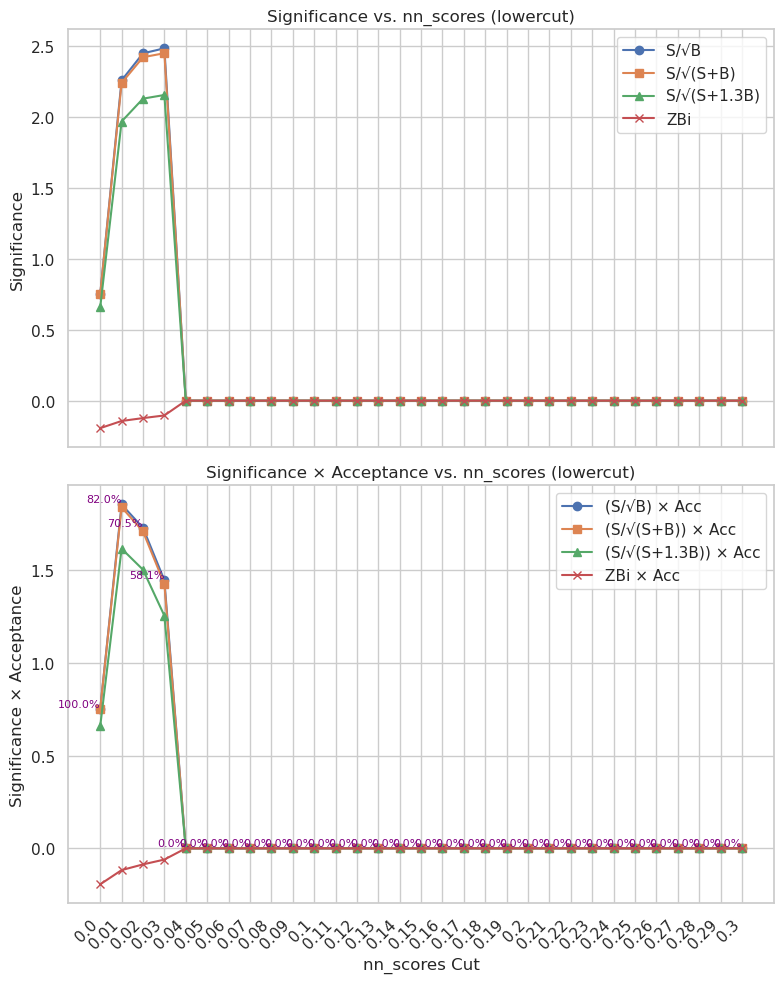

In [8]:
def binomial_significance(s, b):
    return s / np.sqrt(b) if b > 0 else 0

def s_over_sb(s, b):
    return s / np.sqrt(s + b) if (s + b) > 0 else 0

def s_over_s1p3b(s, b):
    return s / np.sqrt(s + 1.3 * b) if (s + 1.3 * b) > 0 else 0

def scan_significance(df, cut_var="nn_scores", cut_type="lowercut", cuts=np.arange(0, 0.71, 0.01)):
    sig_sqrtb = []
    sig_sqrt_sb = []
    sig_sqrt_s1p3b = []
    sig_zbi = []

    sigacc_sqrtb = []
    sigacc_sqrt_sb = []
    sigacc_sqrt_s1p3b = []
    sigacc_zbi = []

    acc_values = []

    df_sig = df[df["label"] == 1]
    df_bkg = df[df["label"] == 0]
    total_sig_weight = df_sig["weights"].sum()

    for cut in cuts:
        if cut_type == "lowercut":
            sig_cut = df_sig[df_sig[cut_var] >= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] >= cut]
        elif cut_type == "uppercut":
            sig_cut = df_sig[df_sig[cut_var] <= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] <= cut]
        else:
            raise ValueError("Invalid cut type")

        s = sig_cut["weights"].sum()
        b = bkg_cut["weights"].sum()
        acceptance = s / total_sig_weight if total_sig_weight > 0 else 0

        # Compute significance
        sig1 = binomial_significance(s, b)
        sig2 = s_over_sb(s, b)
        sig3 = s_over_s1p3b(s, b)
        sig4 = zbi(s, b)

        sig_sqrtb.append(sig1)
        sig_sqrt_sb.append(sig2)
        sig_sqrt_s1p3b.append(sig3)
        sig_zbi.append(sig4)

        sigacc_sqrtb.append(sig1 * acceptance)
        sigacc_sqrt_sb.append(sig2 * acceptance)
        sigacc_sqrt_s1p3b.append(sig3 * acceptance)
        sigacc_zbi.append(sig4 * acceptance)

        acc_values.append(acceptance * 100)

    return cuts, acc_values, sig_sqrtb, sig_sqrt_sb, sig_sqrt_s1p3b, sig_zbi, \
           sigacc_sqrtb, sigacc_sqrt_sb, sigacc_sqrt_s1p3b, sigacc_zbi


def plot_significance(cuts, acc, sig1, sig2, sig3, sig4,
                      sigacc1, sigacc2, sigacc3, sigacc4,
                      cut_var, cut_type, save_path):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    # Plot Significance
    ax1.plot(cuts, sig1, marker='o', label='S/√B')
    ax1.plot(cuts, sig2, marker='s', label='S/√(S+B)')
    ax1.plot(cuts, sig3, marker='^', label='S/√(S+1.3B)')
    ax1.plot(cuts, sig4, marker='x', label='ZBi')

    ax1.set_ylabel('Significance')
    ax1.set_title(f'Significance vs. {cut_var} ({cut_type})')
    ax1.grid(True)
    ax1.legend()

    # Plot Significance × Acceptance
    ax2.plot(cuts, sigacc1, marker='o', label='(S/√B) × Acc')
    ax2.plot(cuts, sigacc2, marker='s', label='(S/√(S+B)) × Acc')
    ax2.plot(cuts, sigacc3, marker='^', label='(S/√(S+1.3B)) × Acc')
    ax2.plot(cuts, sigacc4, marker='x', label='ZBi × Acc')

    for i, txt in enumerate(acc):
        ax2.text(cuts[i], sigacc1[i], f'{txt:.1f}%', fontsize=8, color='purple', ha='right', va='bottom')

    ax2.set_xlabel(f'{cut_var} Cut')
    ax2.set_ylabel('Significance × Acceptance')
    ax2.set_title(f'Significance × Acceptance vs. {cut_var} ({cut_type})')
    ax2.grid(True)
    ax2.legend()
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xticks(cuts)
    ax2.set_xticklabels(cuts, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Saved plot to {save_path}")
    plt.show()


cut_var = "nn_scores"
cut_type = "lowercut"
cut_values = np.arange(0, 0.31, 0.01)

(cuts, acc, sig1, sig2, sig3, sig4,
 sigacc1, sigacc2, sigacc3, sigacc4) = scan_significance(df_ml_input, cut_var, cut_type, cut_values)

plot_significance(
    cuts, acc, sig1, sig2, sig3, sig4,
    sigacc1, sigacc2, sigacc3, sigacc4,
    cut_var=cut_var,
    cut_type=cut_type,
    save_path=f"significance_{cut_var}_{cut_type}.png"
)
